In [1]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
from skimage import img_as_int
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift

In [2]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread
import skimage.external.tifffile as tif
import skimage
import dask.array as da
from dask import delayed
import glob as globby

In [42]:
import configparser
import os.path as op
import cottoncandy as cc
from io import BytesIO
import tempfile
from tempfile import mkdtemp

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('alpenglowoptics')
ll = list(bucket.objects.all())

In [6]:
reflectance = []
for item in ll:
    if item.key.startswith("skin660_488_reflectance/skin2"):
        reflectance.append(item.key)

In [7]:
reflectance[-1]

'skin660_488_reflectance/skin2/skin2_04200.tif'

In [15]:
file_list = ['/skin660_488_reflectance/skin%01d/skin%01d_%05d.tif'%(s, s, i) for s in range(1,4) for i in range(1, 4201) ]

In [16]:
len(file_list)

12600

In [17]:
files_per_strip = 4200
n_strips = 3

In [13]:
# getting our credentials
CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
CP.sections()
ak = CP.get('default', 'AWS_ACCESS_KEY_ID')
sk = CP.get('default', 'AWS_SECRET_ACCESS_KEY')

In [18]:
cci = cc.get_interface('alpenglowoptics', 
                       ACCESS_KEY=ak, 
                       SECRET_KEY=sk,
                       endpoint_url='https://s3.amazonaws.com',
                       verbose=False)

sample = af.s3_to_array(file_list[0], cci)

stack = af.read_strip_files(file_list, files_per_strip, n_strips-1, cci, sample.dtype, sample.shape)
for ss in range(n_strips-2, -1, -1):
    stack = ast.stitch_zstack(
        stack, 
        af.read_strip_files(file_list, files_per_strip, ss, cci, sample.dtype, sample.shape))

ValueError: could not broadcast input array from shape (1426,4200) into shape (1429,4200)

In [19]:
debug

> /home/nicholasreder/alpenglow/alpenglow/stitching.py(197)stitch_zstack()
    195             shift_zero = int(np.round(np.polyval(coef, z_level)))
    196             shift_one = int(np.round(np.mean(shift[:,1])))
--> 197             registered[z_level] = apply_shift(images_1[z_level], images_2[z_level], [shift_zero, shift_one])[:chop_index]
    198 
    199         return registered

ipdb> z_level
0
ipdb> coef
array([ -3.12301925e-03,  -7.58485816e+01])
ipdb> shift_zero
-76
ipdb> shift_one
-23
ipdb> overlap
371
ipdb> u
> <ipython-input-18-da7d4e18320e>(13)<module>()
      9 stack = af.read_strip_files(file_list, files_per_strip, n_strips-1, cci, sample.dtype, sample.shape)
     10 for ss in range(n_strips-2, -1, -1):
     11     stack = ast.stitch_zstack(
     12         stack,
---> 13         af.read_strip_files(file_list, files_per_strip, ss, cci, sample.dtype, sample.shape))

ipdb> d
> /home/nicholasreder/alpenglow/alpenglow/stitching.py(197)stitch_zstack()
    195             sh

In [28]:
cd skin

/home/nicholasreder/alpenglow/data/skin


In [34]:
af.download_s3('skin660_488_reflectance/skin1/skin1_00100.tif', '/home/nicholasreder/alpenglow/data/skin/skin1_00100.tif')  

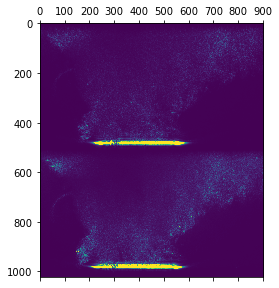

In [36]:
skin1 = tif.imread('/home/nicholasreder/alpenglow/data/skin/skin1_00100.tif')
plt.matshow(skin1)

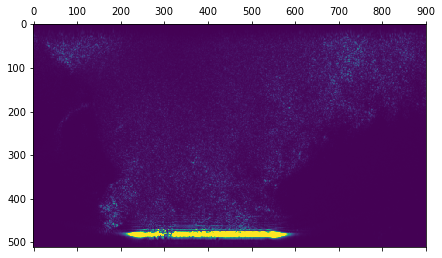

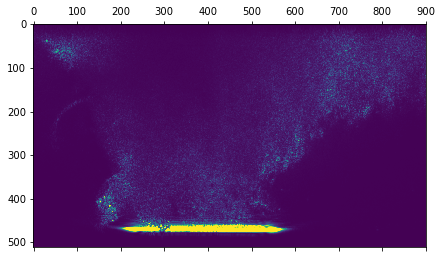

In [39]:
for chan in range(nchan):
    plt.matshow(skin1[:skin1.shape[0]//2,:])
    plt.matshow(skin1[skin1.shape[0]//2:,:])
    
numchan=1

In [45]:
def calc_coef(images_1, images_2, nchan, chan):
    """
    Stitch two z-stacks of tiff strips
    
    Parameters
    ----------
    images_1, images_2 : objects of type ImageCollection, or numpy mem-mapped arrays
    
    nchan : number of channels aquired (int)

    chan : which channel to calculate coefficients (int)

    Returns 
    -------
    Depending on the input: ImageCollection or numpy mem-mapped array
    """
    if nchan > 1:
        images_1 = images_1[chan*images_1.shape[0]//nchan:(chan+1)*images_1.shape[0]//nchan,:]
        images_2 = images_2[chan*images_2.shape[0]//nchan:(chan+1)*images_2.shape[0]//nchan,:]
    
    percentiles = [int(np.percentile(np.arange(len(images_1)), x)) for x in range(10, 100, 10)]
    sub_images_1 = np.zeros((len(percentiles), images_1[0].shape[0], images_1[0].shape[1]))
    sub_images_2 = np.zeros((len(percentiles), images_2[0].shape[0], images_2[0].shape[1]))

    for ii, p in enumerate(percentiles):
        sub_images_1[ii] = images_1[p]
        sub_images_2[ii] = images_2[p]
    
    shift = []
    for x in range(len(sub_images_1)):
        shift.append(find_shift(sub_images_1[x], sub_images_2[x]))
    shift = np.array(shift)
    coef = []
    coef = np.polyfit(percentiles, shift[:,0], 1)
    return coef, shift
    
def output_zstack(images_1, images_2, coef, shift, chop_index, chan=0, current_stack=None, out_path=None):
    
    if isinstance(images_1, skimage.io.collection.ImageCollection):
        # Do the relatively slow thing, but save the results
        if out_path is None:
            out_path = '.'
        if current_stack is None:
            current_stack = 1
        for z_level in range(len(images_1)):
            shift_zero = int(np.round(np.polyval(coef, z_level)))
            shift_one = int(np.round(np.mean(shift[:,1])))
            registered = apply_shift(images_1[z_level], images_2[z_level], [shift_zero, shift_one])
            tiff.imsave(op.join(out_path, "mosaic_chan%06d_%06d_%06d.tif"%(chan, current_stack, z_level+1)), 
                        registered[:chop_index]) 
        return ImageCollection(op.join(out_path, "mosaic_chan%06d_%06d_*.tif"%(chan, current_stack)),
                               plugin="tifffile")
    else:
        # Do the relatively fast thing, without saving
        f3 = op.join(mkdtemp(), 'reg.dat')
        h3 = open(f3, 'w')
        registered = np.memmap(f3, dtype=images_1.dtype, shape=(len(images_1), chop_index, images_1[0].shape[1]))
        for z_level in range(len(images_1)):
            shift_zero = int(np.round(np.polyval(coef, z_level)))
            shift_one = int(np.round(np.mean(shift[:,1])))
            registered[z_level] = apply_shift(images_1[z_level], images_2[z_level], 
                                              [shift_zero, shift_one])[:chop_index]

        return registered

def stitch_zstack(images_1, images_2, nchan, chan=0, current_stack=None, out_path=None):
    coef, shift = calc_coef(images_1, images_2, nchan, chan)
    shift_last = int(np.round(np.polyval(coef, len(images_1))))
    rows = images_1[0].shape[0]+images_2[0].shape[0]
    overlap = (images_2[0].shape[0]//2)+shift_last
    chop_index = int(rows - overlap)
    if nchan == 1:
        return output_zstack(images_1, images_2, coef, shift, chop_index, current_stack=current_stack, out_path=out_path)

    if nchan > 1:       
        if isinstance(images_1, skimage.io.collection.ImageCollection):
            im_collection_list = []
            for chan_index in range(nchan):
                im_collection_list.append(output_zstack(
                    images_1[chan_index*images_1.shape[0]//nchan:(chan_index+1)*images_1.shape[0]//nchan,:],
                    images_2[chan_index*images_2.shape[0]//nchan:(chan_index+1)*images_2.shape[0]//nchan,:], 
                    coef, shift, chop_index, current_stack=current_stack, out_path=out_path))
            all_col_files = []
            for col in im_collection_list:
                all_col_files.extend(col.files)
            return imread_collection(all_col_files)    
        else:
            f3 = op.join(mkdtemp(), 'reg_nchan.dat')
            h3 = open(f3, 'w')
            registered = np.memmap(f3, dtype=images_1.dtype, shape=(nchan, len(images_1)//nchan, 
                                                                    chop_index, images_1[0].shape[1]))
            for chan_index in range(nchan):
                registered[chan_index] = output_zstack(
                    images_1[chan_index*images_1.shape[0]//nchan:(chan_index+1)*images_1.shape[0]//nchan,:],
                    images_2[chan_index*images_2.shape[0]//nchan:(chan_index+1)*images_2.shape[0]//nchan,:], 
                    coef, shift, chop_index, current_stack=current_stack, out_path=out_path)
            return registered 

In [46]:
cci = cc.get_interface('alpenglowoptics', 
                       ACCESS_KEY=ak, 
                       SECRET_KEY=sk,
                       endpoint_url='https://s3.amazonaws.com',
                       verbose=False)

sample = af.s3_to_array(file_list[0], cci)

stack = af.read_strip_files(file_list, files_per_strip, n_strips-1, cci, sample.dtype, sample.shape)
for ss in range(n_strips-2, -1, -1):
    stack = stitch_zstack(
        stack, 
        af.read_strip_files(file_list, files_per_strip, ss, cci, sample.dtype, sample.shape), 2)

ValueError: could not broadcast input array from shape (1386,4200) into shape (1563,4200)

In [ ]:
debug

> <ipython-input-45-4b70b3d52cda>(62)output_zstack()
     60             shift_one = int(np.round(np.mean(shift[:,1])))
     61             registered[z_level] = apply_shift(images_1[z_level], images_2[z_level], 
---> 62                                               [shift_zero, shift_one])[:chop_index]
     63 
     64         return registered

ipdb> chop_index
1563
ipdb> shift
array([[ -55.,    8.],
       [ -59.,    5.],
       [ -53.,    3.],
       [ -74.,    4.],
       [ -82.,    7.],
       [ -78.,   10.],
       [ -94.,   10.],
       [ -80.,    8.],
       [-150.,   16.]])
ipdb> images_1.shape
(512, 900, 4200)
ipdb> images_2.shape
(512, 900, 4200)
ipdb> z_level
0
ipdb> shift_zero
-36
ipdb> shift_last
*** NameError: name 'shift_last' is not defined
ipdb> overlap
*** NameError: name 'overlap' is not defined
ipdb> u
> <ipython-input-45-4b70b3d52cda>(96)stitch_zstack()
     93                 registered[chan_index] = output_zstack(
     94                     images_1[chan_index